In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import lcdata
import os
import matplotlib.pyplot as plt
import itertools
from astropy.table import Table
from tqdm import tqdm
from astropy.time import Time
import pandas as pd
from scipy.interpolate import interp1d
import itertools
from matplotlib.image import NonUniformImage
import multiprocessing as mp
from matplotlib.colors import LogNorm

%matplotlib inline


In [4]:
#filepath where new 2021 data is located
data_2021 = '/global/cfs/cdirs/m4237/desirt/2021_data/lcdata/'
DCDE_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE/'
DCDE2_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE2/'
DCDE3_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE3/'
DCDE4_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE4/'

In [5]:
filelist = [data_2021, DCDE_data, DCDE2_data, DCDE3_data, DCDE4_data]

In [6]:
def band_info(filepath, band):
    '''
    For a given observational band, gets magnitudes, error in magnitude, and files that might have problems. 
    ---
    Inputs:
    ---
    filepath (string): Path to the lcdata hdf5 files to get data from.
    band (string): Band getting info for. options are 'g', 'r', and 'z', but theoretically could input any band.
    ---
    Outputs:
    ---
    bandmags (np.array): Array of all magnitudes in that band.
    bandmagerrs (np.array): Array of all magnitude errors in that band.
    bandfluxes (np.array): Array of all fluxes in that band.
    bandfluxerrs (np.array): Array of all flux errors in that band.
    problem_files (list): List of any files flagged as a problem. This includes ones with unusually/extremely high fluxes and files couldn't get any data from. 
    '''
    bandfluxes = []
    bandsigmaf = []
    problem_files = []
    string = f'lsst{band}'

    for file in os.listdir(filepath):
        if file.endswith('.hdf5'):
            try:
                string_file = os.path.join(filepath, file)
                dataset = lcdata.read_hdf5(string_file)
                dataset_size = len(dataset.light_curves)
                
                for i in range(dataset_size):
                    data = dataset.light_curves[i]
                    bandcol = data[data['band'] == string]
                    band_fluxes = bandcol['flux']
                    band_flux_errors = bandcol['fluxerr']
                    bandfluxes.extend(band_fluxes)
                    bandsigmaf.extend(band_flux_errors)

                    if np.any(band_fluxes >= 4e6):
                        problem_files.append(f'{filepath}{file}')
            except:
                #if unusually high flux in the data flag as potential problem file
                problem_files.append(file)
    
    #if can't get data from the file add it as a problem file
    bandfluxes = np.array(bandfluxes)
    bandsigmaf = np.array(bandsigmaf)
    bandmags = 22.5 - 2.5 * np.log10(bandfluxes)
    bandmagerrs = bandsigmaf/(bandfluxes * (np.log(10)/2.5))
    
    #mask out negative magnitudes (there shouldn't be any) 
    mask = bandmags >= 0
    bandmags = bandmags[mask]
    bandmagerrs = bandmagerrs[mask]
    bandfluxes = bandfluxes[mask]
    bandsigmaf = bandsigmaf[mask]
    
    return bandmags, bandmagerrs, bandfluxes, bandsigmaf, problem_files

In [7]:
def process_band(filelist, band):
    '''
    For a given observational band, determines magnitudes, magnitude errors, and cadences, returned as a dataframe. 
    ---
    Inputs:
    ---
    filelist (list): List of paths to lcdata hdf5 files to get data from.
    band (string): Band getting info for. options are 'g', 'r', and 'z', but theoretically could input any band.
    ---
    Outputs:
    ---
    df (pandas.DataFrame): Dataframe with all fluxes, flux errors, magnitudes and magnitude errors for given band. 
    problem_files (list): List of files flagged as having a problem by band_info function. 
    '''
    all_mags = []
    all_magerrs = []
    all_fluxes = []
    all_fluxerrs = []
    problem_files = []

    #have a progress bar for the files in the filelist
    with tqdm(total=len(filelist), desc=f'Processing band {band}') as pbar:
        for file in filelist:
            try:
                #get mag magerrs flux fluxerrs
                mags, magerrs, fluxes, fluxerrs, band_problem_files = band_info(file, band)
                all_mags.append(mags)
                all_magerrs.append(magerrs)
                all_fluxes.append(fluxes)
                all_fluxerrs.append(fluxerrs)
                problem_files.extend(band_problem_files)
                
            #error handling
            except FileNotFoundError:
                print(f'{file} not found')
            except Exception as e:
                print(f'{file} broke on {band}: {str(e)}')

            pbar.update(1)
            
    #combine the lists of arrays into one array
    all_mags = np.concatenate(all_mags)
    all_magerrs = np.concatenate(all_magerrs)
    all_fluxes = np.concatenate(all_fluxes)
    all_fluxerrs = np.concatenate(all_fluxerrs)
    
    #put info in pandas dataframe
    data = {'mag': all_mags, 'magerr': all_magerrs, 'flux': all_fluxes, 'fluxerr': all_fluxerrs}
    df = pd.DataFrame(data)
    
    return df, problem_files

    

In [8]:
#get data for all bands
bands = ['g', 'r', 'z']
all_bands = {band: process_band(filelist, band) for band in bands}

all_gs, g_problem_files = all_bands['g']
all_rs, r_problem_files = all_bands['r']
all_zs, z_problem_files = all_bands['z']

Processing band z: 100%|██████████| 5/5 [00:56<00:00, 11.25s/it]


In [9]:
#filter out weirdly high flux values -- not sure why these are in the data
all_gs =all_gs[all_gs['flux'] <= 150]
all_rs = all_rs[all_rs['flux'] <= 150]
all_zs = all_zs[all_zs['flux'] <= 150]

In [12]:
print(np.max(all_gs['fluxerr']))

1.4077192544937134


In [10]:
# all_zs = all_zs[all_zs['magerr'] < 0.6]
# print(len(all_zs[all_zs['magerr'] > 0.6]))

In [27]:
def plot2dHist(band_df, band_name, n_x, n_y, factor=100):
    # this just plots a 2d histogram of data
    log_flux = np.log10(band_df['flux'] * factor)
    log_fluxerr = np.log10(band_df['fluxerr'] * factor)

    xedges = np.linspace(log_flux.min(), log_flux.max(), n_x + 1)
    yedges = np.linspace(log_fluxerr.min(), log_fluxerr.max(), n_y + 1)

    H, xedges, yedges = np.histogram2d(log_flux, log_fluxerr, bins=(xedges, yedges))
    H = H.T

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, title='Flux vs Fluxerr, Observations')
    X, Y = np.meshgrid(xedges, yedges)

    # use imshow to get logarithmic color scale
    im = ax.imshow(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], norm=LogNorm(), origin='lower', aspect='auto')
    plt.colorbar(im, label='Counts (log scale)')
    plt.xlabel('log(Flux)')
    plt.ylabel('log(Fluxerr)')
    plt.show()

    return xedges, yedges, H

In [23]:
import numpy as np
from scipy.interpolate import interp1d

def generate_new_error(snana_flux, band_df):
    '''
    Given snana_flux fluxes, determines values for error. 
    ---
    Inputs:
    ---
    snana_flux (array): Array of snana fluxes
    band_df (pd.DataFrame): Dataframe of DECam fluxes and fluxerrs for given band
    ---
    Outputs:
    ---
    new_errors (array): Array of the same size as snana_flux of newly generated errors. 
    '''
    # sort the dataframe by flux
    sorted_df = band_df.sort_values('flux')

    # get sorted arrays for flux and fluxerr from the sorted dataframe
    des_flux_sorted = sorted_df['flux']*100
    des_fluxerr_sorted_by_flux = sorted_df['fluxerr']*100

    new_errors = np.zeros(snana_flux.shape)

    # create a mask for values outside the range of des_flux_sorted
    inside_range_mask = (snana_flux >= des_flux_sorted.iloc[0]) & (snana_flux <= des_flux_sorted.iloc[-1])
    
    outside_range_mask = (snana_flux < des_flux_sorted.iloc[0]) | (snana_flux > des_flux_sorted.iloc[-1])
    # find the indices of the nearest flux values in des_flux_sorted for only those inside the range
    idx = np.searchsorted(des_flux_sorted, snana_flux[inside_range_mask])
    new_errors[inside_range_mask] = des_fluxerr_sorted_by_flux.iloc[idx]
    # print(snana_flux[outside_range_mask])
    
    #fit fluxes outside of range to a linear fit
    slope, intercept = np.polyfit(des_flux_sorted, des_fluxerr_sorted_by_flux, deg=1)
    new_errors[outside_range_mask] = slope * snana_flux[outside_range_mask] + intercept
    # print(new_errors[outside_range_mask])
    return new_errors





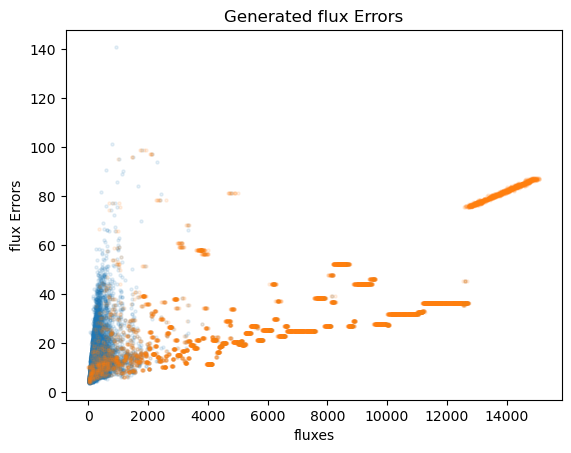

In [29]:
#test new error generation
new_fluxes = np.random.uniform(0.001, 15000, size=7000)  # Replace with your new magnitudes

new_fluxerrs = generate_new_error(new_fluxes, all_gs)
# print(new_fluxes, new_fluxerrs)
new_noise = np.random.normal(0, new_fluxerrs, size = len(new_fluxerrs))
# print(new_noise)
new_flux = new_fluxes + new_noise
# Plotting the new magnitude errors
plt.scatter(all_gs['flux']*100, all_gs['fluxerr']*100, s=5, alpha=0.1)
plt.scatter(new_flux, new_fluxerrs, s=5, alpha=0.1)
data_random = {'flux': new_flux, 'fluxerr': new_fluxerrs}
df_test = pd.DataFrame(data_random)
#plt.scatter(new_magnitudes, new_magnitude_errors, s=5, alpha=0.3)
plt.xlabel('fluxes')
plt.ylabel('flux Errors')
plt.title('Generated flux Errors')
plt.show()

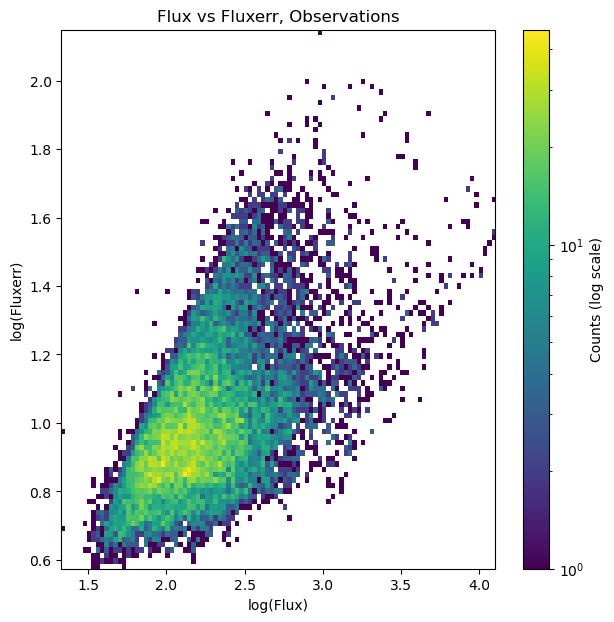

In [25]:
xedge, yedge, hist = plot2dHist(all_gs, 'g', 100, 100)

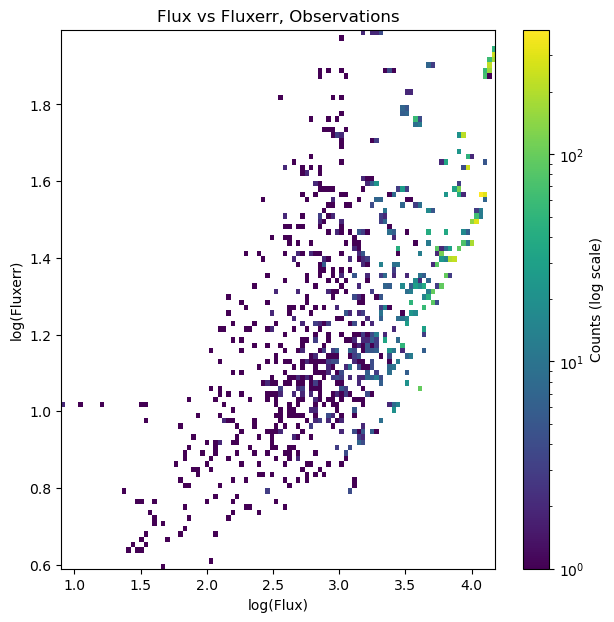

In [30]:
xedge, yedge, hist = plot2dHist(df_test, 'g', 100, 100, factor=1)

In [18]:
def make_noisy(model_name, detection_lim = 1, lightcurve_path='/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noiseless_data/', 
               output_dir='/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/nearest_noise/'):
    '''
    Adds simulated noise to a given lightcurve. Does so by doing a combination nearest neighbor and linear fitting of flux vs 
    uncertainty in flux with fit_function to get error magnitude, then uses np.random.normal to generate gaussian noise using error magnitude as standard deviations.
    Writes modified input hdf5 lcdata to the output_dir with the filename output_dir/{model_name}.hdf5.
    ----------
    Inputs:
    model_name (string): Classification of the lightcurve, ie Cepheid or SNIc
    detection_lim (int): Min number of detections to save data. Default is 1. 
    lightcurve_path (path): Path where .hdf5 lcdata lightcurve is located
    output_dir (path): Directory where you want the output file to be saved
    ---------
    Outputs:
    dataset (hdf5): Writes dataset, a version of the input hdf5 lcdata, to the output_dir with the
                    filename output_dir/01_{model_name}_noisy.hdf5.
    '''
    dataset = lcdata.read_hdf5(f'{lightcurve_path}{model_name}.hdf5')
    new_lcs = []

    #keep count of numbers for printed comparison 
    number_original = 0.
    number_after = 0.

    for i in range(len(dataset.light_curves)):
        data = dataset.light_curves[i]
        # cut to only three bands we need
        number_original += len(data)
        data = data[(data['band'] == 'lsstg') | (data['band'] == 'lsstr') | (data['band'] == 'lsstz')]
        data = data[data['flux'] >= 0]
        
        # generate simulated noise and add it to the fluxes
        noise = np.empty(data['flux'].shape)
        error = np.empty(data['flux'].shape)

        # vectorized calculation of errors and noise for each band
        bands = ['lsstg', 'lsstr', 'lsstz']
        for band in bands:
            mask = (data['band'] == band)
            current_error = generate_new_error(data['flux'][mask], all_gs if band == 'lsstg' else all_rs if band == 'lsstr' else all_zs)
            error[mask] = current_error
            current_noise = np.random.normal(0, current_error, size=np.sum(mask))
            noise[mask] = current_noise

        flux_with_noise = noise + data['flux']
        data['fluxerr'] = error
        data['flux'] = flux_with_noise

        data = data[(data['flux'] > 0) & (data['fluxerr'] > 0)]
        data = data[np.isfinite(data['flux'])]
        #apply snr cut
        data = data[abs(data['flux'] / data['fluxerr']) >= 5]
        number_after += len(data)
        
        #if passes detection cuts add the modified light curve to a list of light curves
        if len(data) >= detection_lim:
            metadata = dataset.meta[i]
            light_curve = Table({
                'time': list(data['time']),
                'flux': list(data['flux']),
                'fluxerr': list(data['fluxerr']),
                'band': list(data['band']),
            })

            light_curve.meta = {
                'object_id': metadata['object_id'],
                'ra': metadata['ra'],
                'dec': metadata['dec'],
                'type': metadata['type'],
                'redshift': metadata['redshift'],
            }
            new_lcs.append(light_curve)


    #write dataset to output location
    new_lc = lcdata.from_light_curves(new_lcs)
    output_path = f'{output_dir}{model_name}_noisy.hdf5'
    os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
    new_lc.write_hdf5(output_path, overwrite=True)
    print(f'Dataset ({len(new_lc)} objects) has been written into {output_path}. Original dataset contained {len(dataset)} light curves')
    print(f'That means it kept {len(new_lc)/len(dataset):0.3%} of the light curves. It kept {number_after/number_original:0.3%} of the observations in total')
    
    return number_after, number_original


In [19]:
obs = ['SNIa-SALT3', 'SNIb+HostXT_V19','SLSN-I+host', 'SNIcBL+HostXT_V19', 'SNIb-Templates', 
       'SNIIb+HostXT_V19', 'KN_K17', 'SNIax', 'TDE', 'SNIIn-MOSFIT', 'SNII-NMF', 'SNIa-91bg', 
       'SLSN-I_no_host', 'SNII-Templates', 'SNIIn+HostXT_V19', 'KN_B19', 'SNII+HostXT_V19', 
       'SNIc-Templates', 'SNIc+HostXT_V19']
    

In [20]:
#use multiprocessing to write 
def process_obs(i):
    make_noisy(obs[i])

if __name__ == '__main__':
    
    with tqdm(total=len(obs), desc='Progress', unit='file') as pbar:
        pool = multiprocessing.Pool()  # Create a multiprocessing pool
        
        # Map the function to each index i in parallel
        results = pool.map(process_obs, range(len(obs)))


Progress:   0%|          | 0/19 [00:00<?, ?file/s]

Dataset (145 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/nearest_noise/KN_B19_noisy.hdf5. Original dataset contained 1528 light curves
That means it kept 9.490% of the light curves. It kept 0.710% of the observations in total
Dataset (779 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/nearest_noise/SLSN-I_no_host_noisy.hdf5. Original dataset contained 3193 light curves
That means it kept 24.397% of the light curves. It kept 1.163% of the observations in total
Dataset (607 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/nearest_noise/KN_K17_noisy.hdf5. Original dataset contained 4823 light curves
That means it kept 12.586% of the light curves. It kept 0.746% of the observations in total
Dataset (5902 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/nearest_noise/SNIc-Templates_n

Progress:   0%|          | 0/19 [27:00<?, ?file/s]
